# Cite-seq / scRNA-seq harmonization

## Imports and data loading

In [1]:
import gzip
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI, Classifier
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import copy

import scanorama
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='2'

set_seed(123)

%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite = True


/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
plt.rcParams['figure.figsize'] = (4, 4)

sc.settings._vector_friendly = True
DPI = 300
W_SPACE = 0.18

Load 111 d1 and 111 d2

In [3]:
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")

Remove unnecessary proteins

In [4]:
keep_pro_111 = np.array([not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]])
anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][:, keep_pro_111]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]

# Filter out unanalyzed clusters
# include_cells = [
#     c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
#     for c in anndataset_111.obs["leiden_subclusters"]
# ]
# anndataset_111 = anndataset_111[include_cells].copy()

anndataset_111_d1 = anndataset_111[anndataset_111.obs["batch_indices"] == 0]
anndataset_111_d2 = anndataset_111[anndataset_111.obs["batch_indices"] == 1]
# gets incremeted later
anndataset_111_d2.obs["batch_indices"] -= 1

Trying to set attribute `.obs` of view, making a copy.


Create scVI dataset objects

In [5]:
hvg_111 = anndataset_111.var["hvg_encode"]

dataset_111_d1 = AnnDatasetFromAnnData(ad=anndataset_111_d1[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111_d1.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111_d1.uns["protein_names"],
)
dataset_111_d1.initialize_cell_measurement(protein_data_111)
dataset_111_d1.gene_names = anndataset_111_d1[:, hvg_111].var_names.values

dataset_111_d2 = AnnDatasetFromAnnData(ad=anndataset_111_d2[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111_d2.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111_d2.uns["protein_names"],
)
dataset_111_d2.initialize_cell_measurement(protein_data_111)
dataset_111_d2.gene_names = anndataset_111_d2[:, hvg_111].var_names.values

[2020-09-04 11:40:59,884] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-04 11:40:59,887] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-04 11:40:59,949] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-04 11:41:00,011] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells
[2020-09-04 11:41:00,450] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-04 11:41:00,453] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-04 11:41:00,504] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-04 11:41:00,556] INFO - scvi.dataset.dataset | Downsampled from 7564 to 7564 cells


Make 111 d2 all zero and store real values. Calculate batch mask. All zero proteins are "imputed", no backprop through them

### add noise protein

In [6]:
dataset = GeneExpressionDataset()
# Protein panels intersected
dataset.populate_from_datasets(
    [copy.deepcopy(dataset_111_d1), copy.deepcopy(dataset_111_d2)],
)

# add random protein
dataset.protein_expression = np.concatenate([dataset.protein_expression, np.random.negative_binomial(10, 0.2, size=(dataset.protein_expression.shape[0], 1))], axis=1)
dataset.protein_names = np.concatenate([dataset.protein_names, ["random"]])

held_out_proteins = dataset.protein_expression[
    dataset.batch_indices.ravel() == 1
].copy()

dataset.protein_expression[dataset.batch_indices.ravel() == 1] = np.zeros_like(
    dataset.protein_expression[dataset.batch_indices.ravel() == 1]
)
batch_mask = dataset.get_batch_mask_cell_measurement("protein_expression")

[2020-09-04 11:41:01,832] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-09-04 11:41:01,962] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-04 11:41:02,059] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-04 11:41:02,062] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-04 11:41:02,168] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-04 11:41:02,249] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-04 11:41:02,252] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-04 11:41:02,598] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-04 11:41:02,600] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-04 11:41:02,602] INFO - scvi.dataset.dataset | Keeping 110 columns in protein_expression


In [7]:
# Batch mask for second batch should be all 0 because it's proteins are held-out
batch_mask[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [8]:
dataset.protein_names

array(['ADT_CD102_A0104', 'ADT_CD103_A0201', 'ADT_CD106_A0226',
       'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012',
       'ADT_CD11a_A0595', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227',
       'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195',
       'ADT_CD135_A0098', 'ADT_CD137_A0194', 'ADT_CD140a_A0573',
       'ADT_CD14_A0424', 'ADT_CD15(SSEA-1)_A0076',
       'ADT_CD150(SLAM)_A0203', 'ADT_CD16-32_A0109',
       'ADT_CD169(Siglec-1)_A0440', 'ADT_CD172a(SIRPa)_A0422',
       'ADT_CD183(CXCR3)_A0228', 'ADT_CD184(CXCR4)_A0444',
       'ADT_CD192(CCR2)_A0426', 'ADT_CD195(CCR5)_A0376',
       'ADT_CD196(CCR6)_A0225', 'ADT_CD197(CCR7)_A0377', 'ADT_CD19_A0093',
       'ADT_CD200(OX2)_A0079', 'ADT_CD201(EPCR)_A0439',
       'ADT_CD204(Msr1)_A0448', 'ADT_CD206(MMR)_A0173', 'ADT_CD20_A0192',
       'ADT_CD21-CD35(CR2-CR1)_A0107', 'ADT_CD223(LAG-3)_A0378',
       'ADT_CD23_A0108', 'ADT_CD24_A0212', 'ADT_CD25_A0097',
       'ADT_CD274(B7-H1_PD-L1)_A0190', 'ADT_CD278(ICOS)_A0171',
 

## Model creation and training

In [9]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset.n_batches,
    encoder_batch=True,
    protein_batch_mask=batch_mask,
    n_layers_decoder=1,
    n_layers_encoder=1
)

use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.9,
    test_size=0.1,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory":False},
    early_stopping_kwargs=early_stopping_kwargs,
    use_adversarial_loss=True,
    kappa=None,
)

In [10]:
trainer.train(lr=lr, n_epochs=500)

[2020-09-04 11:57:18,087] INFO - scvi.inference.trainer | Reducing LR on epoch 248.
[2020-09-04 11:58:12,256] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-09-04 11:58:12,258] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


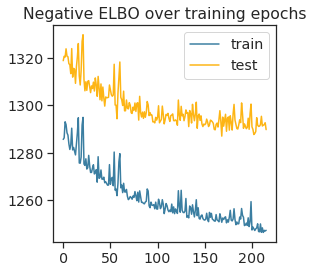

In [11]:
plt.plot(trainer.history["elbo_train_set"][50:], label="train")
plt.plot(trainer.history["elbo_test_set"][50:], label="test")
plt.title("Negative ELBO over training epochs")
plt.legend()

## Posterior creation and analysis

In [12]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=25, give_mean=True, transform_batch=0
)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

n_samples=25

# Probability of background
py_mixing = np.mean(
    sigmoid(
        full_posterior.sequential().get_sample_mixing(
            n_samples=n_samples, give_mean=False, transform_batch=0
        )
    ),
    axis=-1,
)
protein_foreground_prob_imputed = pd.DataFrame(
    data=(1 - py_mixing), columns=dataset.protein_names
)
protein_foreground_prob_imputed = protein_foreground_prob_imputed.iloc[dataset.batch_indices.ravel() == 1]

In [13]:
protein_means = full_posterior.sequential().get_protein_mean(n_samples=25, transform_batch=0, give_mean=True)
# protein_means = np.median(protein_means, axis=-1)
imputed_proteins = protein_means[dataset.batch_indices.ravel() == 1]

In [20]:
import torch 
from torch.distributions import Bernoulli, Gamma, Poisson
@torch.no_grad()
def generate_transform(
    self,
    n_samples: int = 2,
    transform_batch=0,
    genes = None,
    batch_size: int = 64,
):  # with n_samples>1 return original list/ otherwise sequential
    """
    Return samples from posterior predictive. Proteins are concatenated to genes.
    :param n_samples:
    :param genes:
    :return:
    """
    original_list = []
    posterior_list = []
    for tensors in self.update({"batch_size": batch_size}):
        x, _, _, batch_index, labels, y = tensors
        with torch.no_grad():
            outputs = self.model.inference(
                x, y, batch_index=batch_index, label=labels, n_samples=n_samples, transform_batch=transform_batch
            )
        px_ = outputs["px_"]
        py_ = outputs["py_"]

        pi = 1 / (1 + torch.exp(-py_["mixing"]))
        mixing_sample = Bernoulli(pi).sample()
        protein_rate = (
            py_["rate_fore"] * (1 - mixing_sample)
            + py_["rate_back"] * mixing_sample
        )
        rate = torch.cat((px_["rate"], protein_rate), dim=-1)
        if len(px_["r"].size()) == 2:
            px_dispersion = px_["r"]
        else:
            px_dispersion = torch.ones_like(x) * px_["r"]
        if len(py_["r"].size()) == 2:
            py_dispersion = py_["r"]
        else:
            py_dispersion = torch.ones_like(y) * py_["r"]

        dispersion = torch.cat((px_dispersion, py_dispersion), dim=-1)

        # This gamma is really l*w using scVI manuscript notation
        p = rate / (rate + dispersion)
        r = dispersion
        l_train = Gamma(r, (1 - p) / p).sample()
        data = Poisson(l_train).sample().cpu().numpy()
        # """
        # In numpy (shape, scale) => (concentration, rate), with scale = p /(1 - p)
        # rate = (1 - p) / p  # = 1/scale # used in pytorch
        # """
        original_list += [np.array(torch.cat((x, y), dim=-1).cpu())]
        posterior_list += [data]

        if genes is not None:
            posterior_list[-1] = posterior_list[-1][
                :, :, self.gene_dataset._gene_idx(genes)
            ]
            original_list[-1] = original_list[-1][
                :, self.gene_dataset._gene_idx(genes)
            ]

        posterior_list[-1] = np.transpose(posterior_list[-1], (1, 2, 0))

    return (
        np.concatenate(posterior_list, axis=0),
        np.concatenate(original_list, axis=0),
    )

In [23]:
sampled_imputed_proteins, _ = generate_transform(full_posterior.sequential())

In [25]:
sampled_imputed_proteins = sampled_imputed_proteins[dataset.batch_indices.ravel() == 1]
sampled_imputed_proteins = sampled_imputed_proteins[:, :, 0]
sampled_imputed_proteins.shape

(7564, 4116)

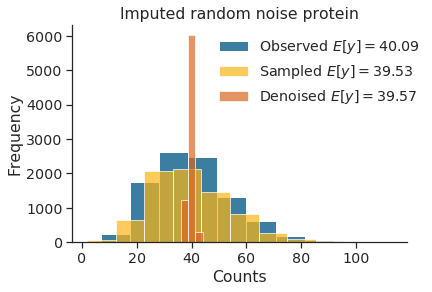

In [33]:
obs_protein = dataset.protein_expression[
    dataset.batch_indices.ravel() == 0
].copy()
ex_obs = obs_protein[:, -1].mean()
ex_imp = imputed_proteins[:, -1].mean()
ex_imp_samp = sampled_imputed_proteins[:, -1].mean()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(obs_protein[:, -1], label=r"Observed $E[y] = ${:.2f}".format(ex_obs))
ax.hist(sampled_imputed_proteins[:, -1], alpha=0.7, label="Sampled $E[y] = ${:.2f}".format(ex_imp_samp))
ax.hist(imputed_proteins[:, -1], bins=5, label="Denoised $E[y] = ${:.2f}".format(ex_imp), alpha=0.7)
ax.legend(frameon=False, bbox_to_anchor=(0.4, 1))
ax.set_title("Imputed random noise protein")
ax.set_xlabel("Counts")
ax.set_ylabel("Frequency")
sns.despine()
fig.savefig("figures/random_noise_imputation.pdf", bbox_inches="tight")

In [23]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.var.index = dataset.gene_names
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=25, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.3, n_components=2)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.6)
names = ["SLN111-D1", "SLN111-D2 No proteins"]
post_adata.obs["batch_indices"] = np.array([names[b] for b in dataset.batch_indices.ravel()])

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/p

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical


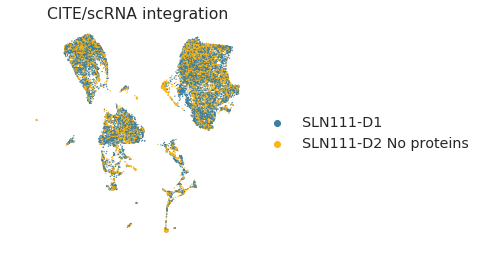

In [24]:
perm_inds = np.random.permutation(len(post_adata))
fig = sc.pl.umap(
    post_adata[perm_inds], 
    color=["batch_indices"],
    title="CITE/scRNA integration",
    return_fig=True,
    frameon=False
)
# sns.despine(fig=fig)
# plt.savefig("figures/cite_scrna_umap.pdf", dpi=DPI, bbox_inches="tight")

Trying to set attribute `.obs` of view, making a copy.
... storing 'batch_indices' as categorical


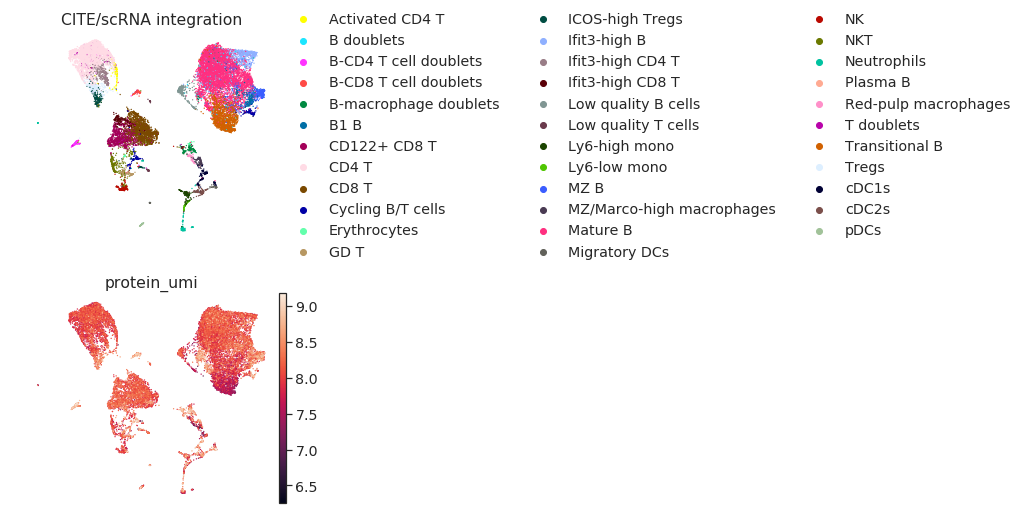

In [30]:
post_adata.obs["cell_types"] = anndataset_111.obs.cell_types.values
post_adata.obs["protein_umi"] = np.log(anndataset_111.obsm["protein_expression"].sum(1))



perm_inds = np.random.permutation(len(post_adata))
fig = sc.pl.umap(
    post_adata[perm_inds], 
    color=["cell_types", "protein_umi"],
    title="CITE/scRNA integration",
    return_fig=True,
    frameon=False,
    ncols=1
)

In [32]:
post_adata_b1 = post_adata[dataset.batch_indices.ravel() == 1].copy()
percentiles = {}
for i, p_long in enumerate(dataset.protein_names):
    try:
        p = p_long.split("_")[1].split("(")[0]
    except IndexError:
        p = p_long
    post_adata_b1.obs["{} imputed".format(p)] = np.log1p(imputed_proteins[:, i])
    post_adata_b1.obs["{} observed".format(p)] = np.log1p(held_out_proteins[:, i])
    post_adata_b1.obs["{} probability foreground".format(p)] = protein_foreground_prob_imputed.loc[:, p_long].values
    percentiles[p] = np.percentile(np.log1p(held_out_proteins[:, i]), 99)

... storing 'batch_indices' as categorical


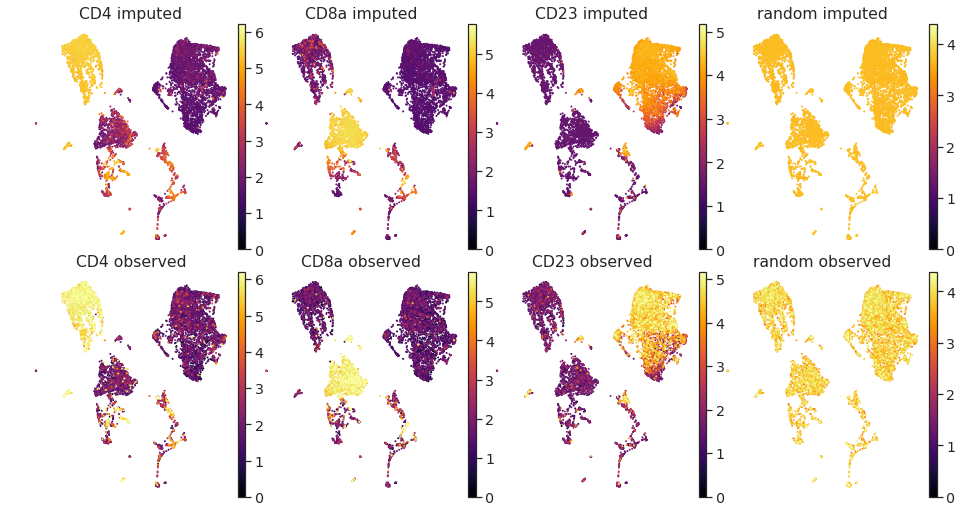

In [33]:
perm_inds = np.random.permutation(len(post_adata))
proteins = ["CD4", "CD8a", "CD23", "random"]
colors = np.concatenate([[[p + " imputed"]  for p in proteins] + [[p + " observed"] for p in proteins]]).ravel()
vmax = [percentiles[p] for p in proteins]
vmax += vmax
fig = sc.pl.umap(
    post_adata_b1, 
    color=colors,
    return_fig=True,
    frameon=False,
    color_map="inferno",
    ncols=4,
#     vmax=[None] * 4 + ["p99"] * 4
    vmax = vmax,
    vmin = 0,
    wspace=0.003,
    hspace=0.1
)
# plt.savefig("figures/imputed_vs_obs_umaps.pdf", dpi=DPI, bbox_inches="tight")